# Weather and Motor Vehicle Collisions

In [2]:
import pandas as pd
import numpy as np
import datetime
from datetime import date
from dateutil.rrule import rrule, DAILY
from __future__ import division
import geoplotlib as glp
from geoplotlib.utils import BoundingBox, DataAccessObject

pd.set_option('display.max_columns', None)
%matplotlib inline  

## Download weather data

In [ ]:
start_date = date(2012, 7, 1)
end_date = date(2016, 2, 29)

# data = pd.DataFrame()
frames = []
url_template = 'https://www.wunderground.com/history/airport/KNYC/%s/%s/%s/DailyHistory.html?req_city=New+York&req_state=NY&req_statename=New+York&reqdb.zip=10001&reqdb.magic=4&reqdb.wmo=99999&format=1.csv'

month = ""

for dt in rrule(DAILY, dtstart=start_date, until=end_date):
    if (month != dt.strftime("%m")):
        month = dt.strftime("%m")
        print 'Downloading to memory: ' + dt.strftime("%Y-%m")    
    frames.append(pd.read_csv(url_template % (dt.strftime("%Y"),dt.strftime("%m"), dt.strftime("%d"))))

print "Saving data to csv..."
data = pd.concat(frames)
data.to_csv('weather_data_nyc.csv', sep=',')

## Cleaning the weather dataset
### Convert weather DateUTC to local time

In [ ]:
from datetime import datetime
from dateutil import tz

weather = pd.read_csv('datasets/weather_data_nyc_clean.csv')

def UTCtoActual(utcDate):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')
    
    utc = datetime.strptime(utcDate.DateUTC, '%m/%d/%Y %H:%M:%S')\
                  .replace(tzinfo=from_zone)\
                  .astimezone(to_zone)
    s = pd.Series([utc.year, utc.month, utc.day, utc.hour])
    s.columns = ['Year', 'Month', 'Day', 'Hour']
    return s
    
#weather['DateActual'] = weather.DateUTC.map()

In [ ]:
weather[['Year', 'Month', 'Day', 'Hour']] = weather.apply(UTCtoActual, axis=1)
weather.to_csv('datasets/weather_data_nyc_clean2.csv')

### Merge weather and NYPD MVC datasets

In [ ]:
incidents = pd.read_csv('datasets/NYPD_Motor_Vehicle_Collisions.csv')
weather = pd.read_csv('datasets/weather_data_nyc_clean2.csv')
weather.head(1)

In [ ]:
weather[(weather.Year == 2015) & (weather.Month == 11) & (weather.Day == 27)]

In [ ]:
features0 = ['Conditions', 'TemperatureC']
features = ['Conditions', 'Precipitationmm',\
            'TemperatureC', 'VisibilityKm']

def lookup_weather2(year, month, day, hour):
    w = weather[(weather.Year == year) & (weather.Month == month) & (weather.Day == day) & (weather.Hour == hour)]
    return w

def lookup_weather(date, time):
    month = int(date.split('/')[0])
    day = int(date.split('/')[1])
    year = int(date.split('/')[2])
    hour = int(time.split(':')[0])
    d = lookup_weather2(year, month, day, hour).head(1)
    if (d.empty):
        dt_back = datetime.datetime(year, month, day, hour) - datetime.timedelta(hours=1)
        dt_forward = datetime.datetime(year, month, day, hour) + datetime.timedelta(hours=1)
        
        d_back = lookup_weather2(dt_back.year, dt_back.month, dt_back.day, dt_back.hour)
        if (not d_back.empty): return d_back
        
        d_forward = lookup_weather2(dt_forward.year, dt_forward.month, dt_forward.day, dt_forward.hour)
        if (not d_forward.empty): return d_forward
    return d



def merge_weather(incident):
    date = incident.DATE
    time = incident.TIME
    #print "0"
    w = lookup_weather(date, time)
    #[unnamed, condition, dateUTC, Dew, Events, Gust, Humidity,Precipitationmm,Sea_Level_PressurehPa, TemperatureC] = w.values[0]

    #print "1"
    try:
        #print "2"
        #print w
        con = "-"
        temp = "-"
        rainmm = "-"
        viskm = "-"
        #print "2.5"
        if (not pd.isnull(w['Conditions'].iloc[0])):
            con = w['Conditions'].iloc[0]
        if (not pd.isnull(w['TemperatureC'].iloc[0])):
            temp = w['TemperatureC'].iloc[0]
        if (not pd.isnull(w['Precipitationmm'].iloc[0])):
            rainmm = w['Precipitationmm'].iloc[0]
        if (not pd.isnull(w['VisibilityKm'].iloc[0])):
            viskm = w['VisibilityKm'].iloc[0]
            
        #print 'con %s, temp %s, rainmm %s, viskm %s' % (con, temp, rainmm, viskm)
        
        #print "2.75"
        s = pd.Series([con, rainmm, temp, viskm])
        #print "3"
        #print str(len(w.values[0]))
        #s = pd.Series(w.values[0])
        #s = pd.Series([w['Conditions'].iloc[0], w['Dew PointC'].iloc[0], w['Gust SpeedKm/h'].iloc[0]])

        #s.columns = features
        return s
    except:
        #print "4"
        print date + "x" + time
        s = pd.Series([None,None,None,None])
        #s = pd.Series(["1","2","3","4","5","6","7","8","9"])
        #s = pd.Series([])
        #s.columns = features
        return s
    
    
    

#lookup_weather2(2016, 2, 14, 7)
#lookup_weather('03/14/2016', '3:27').values[0]
#[unnamed, condition, dateUTC, Dew, Events, Gust, Humidity,Precipitationmm,Sea_Level_PressurehPa, TemperatureC] = lookup_weather('01/27/2016', '3:27').values[0]

In [ ]:
print "Applying weather data to incidents..."
incidents[features] = incidents[incidents.DATE.str.split('/').str.get(2) != '2016'].apply(merge_weather, axis=1)
print "Saving weather in-riched incident data..."
incidents.to_csv('datasets/NYPD_Motor_Vehicle_Collisions_weather3.csv', sep=',')

In [ ]:
incidents[incidents.DATE.str.split('/').str.get(2) == '2016']

## Make some nice data analysis

In [17]:
# Read dataset
incidents = pd.read_csv('datasets/NYPD_Motor_Vehicle_Collisions_weather3.csv')
# Filter 2016 incidents
incidents = incidents[(incidents.DATE.str.split('/').str.get(2) != '2016') 
                      & (pd.notnull(incidents.Conditions))]

In [ ]:
# Distribution of incidents by weather conditions
ys = []
xs = []

for c in incidents.Conditions.unique():
    mask = (incidents.Conditions == c)
    filtered_incidents = incidents[mask]
    ys.append(len(filtered_incidents.index))
    xs.append(c)

df = pd.DataFrame(pd.Series(ys, index=xs, name="Incidents by weather conditions").sort_values())
df.plot(kind='barh', figsize=(8,8))

In [ ]:
df

**Now lets try to find out if there are any condition that causes more incidents than others. We do this by plotting out heatmaps to get an idea of the distributions in the NYC area**

In [ ]:
def plot_zip_weather(condition, data):
    ys = []
    xs = []

    for z in data['ZIP CODE'].unique():
        mask = (data['ZIP CODE'] == z)
        filtered_incidents = data[mask]
        ys.append(len(filtered_incidents.index))
        xs.append(z)

    df = pd.DataFrame(pd.Series(ys, index=xs, name="%s incidents by zip code" % condition).sort_values())
    df.plot(kind='barh', figsize=(8,32))

def draw_kde(data):
    bbox = BoundingBox(north=data.LATITUDE.max()-0.055,\
                       west=data.LONGITUDE.min()+0.055,\
                       south=data.LATITUDE.min()-0.055,\
                       east=data.LONGITUDE.max()+0.055)

    coords = {'lat': data.LATITUDE.values.tolist(), 'lon': data.LONGITUDE.values.tolist()}
    
    glp.kde(coords, bw=5, cut_below=1e-4)
    glp.set_bbox(bbox)
    glp.inline()
    
def plot_stuff(conditions, data):
    print "%s conditions" % conditions 
    plot_zip_weather(conditions, data)
    draw_kde(data)

snowy = incidents[incidents['Conditions'].str.contains('Snow')]
rainy = incidents[incidents['Conditions'].str.contains('Rain')]
clear = incidents[incidents['Conditions'].str.contains('Clear')]
cloudy = incidents[(incidents['Conditions'].str.contains('Cloud')) | (incidents['Conditions'].str.contains('Overcast'))]
haze = incidents[incidents['Conditions'].str.contains('Haze')]
plot_stuff("Snowy", snowy)
plot_stuff("Rainy", rainy)
plot_stuff("Clear", clear)
plot_stuff("Cloudy", cloudy)
plot_stuff("Hazy", haze)

**Finding the ratio between conditions that resulted in an incident. Borough level**

In [ ]:
# What is the probability of an incident based on the weather condition?
# Normalize incidents based on the conditions.

from collections import Counter
ConditionIncidentCounter = Counter(incidents.Conditions.values)

p_incident = {}
for k,v in ConditionIncidentCounter.most_common():
    p_incident[k] = v/len(incidents)

p_incident

# Do the same again but for individual areas of NYC
p_incident_district = {}
l = len(incidents)
for district in incidents[pd.notnull(incidents.BOROUGH)].BOROUGH.unique():
    filtered = incidents[incidents.BOROUGH == district]
    counter = Counter(filtered.Conditions.values)
    p_incident_district[district] = {}
    for k,v in counter.most_common():
            p_incident_district[district][k] = v / len(list(counter.elements()));
            
p_incident_district

# Are there any areas in NYC that experience incidents based 
#  on a condition unusually higher or lower compared to other areas?
# Calculate the ratio of incidents based on the condition.
def calcRatioForDistrict(districtCounter, overAllCounter, district):
    ys = []
    xs = []
    for con in incidents.Conditions.unique():
        ys.append(districtCounter[con] / overAllCounter[con])
        xs.append(con)
    return pd.Series(ys, index=xs)
    
series = {}
for b in incidents[pd.notnull(incidents.BOROUGH)].BOROUGH.unique():
    series[b] = calcRatioForDistrict(p_incident_district[b], p_incident, b)

df = pd.DataFrame(series)
df.plot(kind="bar", subplots=True, figsize=(14,14),layout=(7,2), legend=False,sharey=True)

**Let's try to look at zip codes in Brooklyn only**

In [ ]:
# What is the probability of an incident based on the weather condition?
# Normalize incidents based on the conditions.

from collections import Counter
borough = incidents[incidents.BOROUGH == 'MANHATTAN']
ConditionIncidentCounter = Counter(borough.Conditions.values)

p_incident = {}
for k,v in ConditionIncidentCounter.most_common():
    p_incident[k] = v/len(borough)

p_incident

# Do the same again but for individual areas of NYC
p_incident_borough_zip = {}
l = len(borough)
for z in borough[pd.notnull(incidents['ZIP CODE'])]['ZIP CODE'].unique():
    filtered = borough[incidents['ZIP CODE'] == z]
    counter = Counter(filtered.Conditions.values)
#     z = str(z).split(".")[0]
    p_incident_borough_zip[z] = {}
    for k,v in counter.most_common():
        p_incident_borough_zip[z][k] = v / len(list(counter.elements()));
            
p_incident_borough_zip

# Are there any areas in NYC that experience incidents based 
#  on a condition unusually higher or lower compared to other areas?
# Calculate the ratio of incidents based on the condition.
def calcRatioForDistrict(districtCounter, overAllCounter, district):
    ys = []
    xs = []
    for con in incidents.Conditions.unique():
        if (con in districtCounter):
            ys.append(districtCounter[con] / overAllCounter[con])
        else:
            ys.append(0)
        xs.append(con)
    return pd.Series(ys, index=xs)
    
series = {}
for z in borough[pd.notnull(incidents['ZIP CODE'])]['ZIP CODE'].unique():
    series[z] = calcRatioForDistrict(p_incident_borough_zip[z], p_incident, b)

df = pd.DataFrame(series)

In [ ]:
df.plot(kind="bar", subplots=True, figsize=(14,100), layout=(50,2), legend=False, sharey=False)

In [ ]:
worst_day = incidents.DATE.value_counts().index[0]
worst_day_count = incidents.DATE.value_counts()[0]

incidents[incidents.DATE == worst_day]

In [ ]:
incidents.DATE.value_counts()

In [10]:
incidents['CONTRIBUTING FACTOR VEHICLE 1'].unique()

array(['Unspecified', 'Outside Car Distraction', 'Other Vehicular',
       'Traffic Control Disregarded', 'Turning Improperly',
       'Driver Inattention/Distraction', 'Failure to Yield Right-of-Way',
       'Backing Unsafely', 'Physical Disability', 'Lost Consciousness',
       'Oversized Vehicle', 'Obstruction/Debris', 'Driver Inexperience',
       'Prescription Medication', 'Fatigued/Drowsy', 'Alcohol Involvement',
       'Pavement Slippery', 'Passenger Distraction',
       'View Obstructed/Limited', 'Pavement Defective',
       'Aggressive Driving/Road Rage', nan, 'Animals Action',
       'Tire Failure/Inadequate', 'Passing or Lane Usage Improper',
       'Unsafe Speed', 'Illness', 'Fell Asleep', 'Cell Phone (hands-free)',
       'Brakes Defective', 'Drugs (Illegal)', 'Other Electronic Device',
       'Following Too Closely', 'Lane Marking Improper/Inadequate',
       'Unsafe Lane Changing', 'Steering Failure',
       'Cell Phone (hand-held)', 'Glare', 'Failure to Keep Right',
   

## Looking at weather based causes

In [3]:
# Read dataset
incidents = pd.read_csv('datasets/NYPD_Motor_Vehicle_Collisions_weather4.csv')
# Filter 2016 incidents
incidents = incidents[(incidents.DATE.str.split('/').str.get(2) != '2016') 
                      & (pd.notnull(incidents.Conditions))]

/Users/masve/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
def count_contributing(cont):
    temp = incidents[(incidents['CONTRIBUTING FACTOR VEHICLE 1'] == cont) | \
                     (incidents['CONTRIBUTING FACTOR VEHICLE 2'] == cont) | \
                     (incidents['CONTRIBUTING FACTOR VEHICLE 3'] == cont) | \
                     (incidents['CONTRIBUTING FACTOR VEHICLE 4'] == cont) | \
                     (incidents['CONTRIBUTING FACTOR VEHICLE 5'] == cont) ]
    return temp.shape[0]

print "Accidents caused by Pavement Slippery: %s" % count_contributing('Pavement Slippery')
print "Accidents caused by Glare: %s " % count_contributing('Glare')
print "Accidents caused by Pavement Defective: %s " % count_contributing('Pavement Defective')

Accidents caused by Pavement Slippery: 8426
Accidents caused by Glare: 1491 
Accidents caused by Pavement Defective: 889 


There seems to be a lot of incidents caused by slippery pavement. Let's look at the weather conditions for those incidents.

In [5]:
weather_incidents = incidents[(incidents['CONTRIBUTING FACTOR VEHICLE 1'] == 'Pavement Slippery') | \
                              (incidents['CONTRIBUTING FACTOR VEHICLE 2'] == 'Pavement Slippery') | \
                              (incidents['CONTRIBUTING FACTOR VEHICLE 3'] == 'Pavement Slippery') | \
                              (incidents['CONTRIBUTING FACTOR VEHICLE 4'] == 'Pavement Slippery') | \
                              (incidents['CONTRIBUTING FACTOR VEHICLE 5'] == 'Pavement Slippery') ]

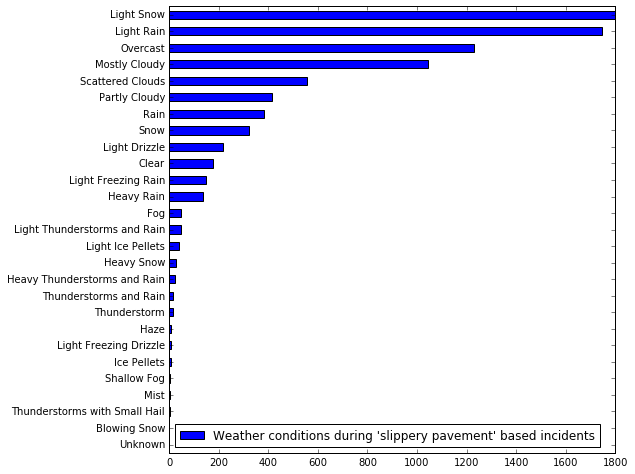

In [15]:
# Distribution of incidents by weather conditions
ys = []
xs = []

for c in weather_incidents.Conditions.unique():
    mask = (weather_incidents.Conditions == c)
    filtered_incidents = weather_incidents[mask]
    ys.append(filtered_incidents.shape[0])
    xs.append(c)

df = pd.DataFrame(pd.Series(ys, index=xs, name="Weather conditions during 'slippery pavement' based incidents").sort_values())
df.plot(kind='barh', figsize=(8,8))

# Export to json for d3 viz
from collections import OrderedDict
import json
with open('datasets/slippery_pavement.json', 'w') as fp:
    json.dump(OrderedDict(sorted(dict(zip(xs, ys)).items(), key=lambda x: x[1], reverse=True)), fp)

Okay, the overcast and clear weather still are the top 2. The assumption that the type of incidents are caused by weather conditions might still hold true. It could be that top 2 are caused by pavement conditions independent of the weather, such as water or oil on the roads. In any case, lets try to plot out where these incidents occur.

In [7]:
def draw_dot(data, type_color):
    bbox = BoundingBox(north=incidents.LATITUDE.max()-0.055,\
               west=incidents.LONGITUDE.min()+0.055,\
               south=incidents.LATITUDE.min()-0.055,\
               east=incidents.LONGITUDE.max()+0.055)
    
    gridDots = {'lat': data.LATITUDE.values.tolist(), 'lon': data.LONGITUDE.values.tolist()}
    
    glp.set_bbox(bbox)
    glp.dot(gridDots, color=type_color)
    
def get_spaced_colors(n):
    max_value = 16581375 #255**3
    interval = int(max_value / n)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]
    
    return [[int(i[:2], 16), int(i[2:4], 16), int(i[4:], 16), 255] for i in colors]

colormap = get_spaced_colors(weather_incidents['Conditions'].unique().size)
    
for idx, wi in enumerate(weather_incidents['Conditions'].unique().tolist()):
    filtered = weather_incidents[weather_incidents['Conditions'] == wi]
#     print "%s %s" % (wi, str(filtered.size))
    draw_dot(filtered, colormap[idx])
#     draw_dot(filtered, 'r')

glp.inline()

Looking at the intersections we can find those most dangerous based on the number of incidents happening there which are in some way caused by slippery pavement.

In [8]:
weather_incidents.LOCATION.value_counts()[:5]

(40.5732661, -74.1469613)    13
(40.7887968, -73.9375408)    12
(40.8726198, -73.9046763)    12
(40.7621739, -73.7567868)    11
(40.8221447, -73.8878132)    11
Name: LOCATION, dtype: int64

Ignoring incidents happening outside intersections the top 3 looks like this:

1. 40.5732661, -74.1469613 ([Google Street View](https://www.google.dk/maps/place/40%C2%B034'23.8%22N+74%C2%B008'49.1%22W/@40.5732939,-74.1469447,3a,75y,164.98h,67.57t/data=!3m7!1e1!3m5!1sRjO41stQiWcqnQNAX-ttDg!2e0!6s%2F%2Fgeo0.ggpht.com%2Fcbk%3Fpanoid%3DRjO41stQiWcqnQNAX-ttDg%26output%3Dthumbnail%26cb_client%3Dmaps_sv.tactile.gps%26thumb%3D2%26w%3D203%26h%3D100%26yaw%3D40.93285%26pitch%3D0!7i13312!8i6656!4m2!3m1!1s0x0:0x0))
2. 40.8726198, -73.9046763 ([Google Street View](https://www.google.dk/maps/@40.8726885,-73.9046913,3a,75y,163.82h,80.07t/data=!3m6!1e1!3m4!1s-d-XL7AoJl7Q1eUZduCvmQ!2e0!7i13312!8i6656))
3. 40.7460347, -73.9344002 ([Google Street View](https://www.google.dk/maps/place/40%C2%B044'45.7%22N+73%C2%B056'03.8%22W/@40.7460666,-73.9343761,3a,75y,270.71h,64.54t/data=!3m7!1e1!3m5!1spNL3ai3azjLYbbiK4tPwFA!2e0!6s%2F%2Fgeo3.ggpht.com%2Fcbk%3Fpanoid%3DpNL3ai3azjLYbbiK4tPwFA%26output%3Dthumbnail%26cb_client%3Dmaps_sv.tactile.gps%26thumb%3D2%26w%3D203%26h%3D100%26yaw%3D26.574732%26pitch%3D0!7i13312!8i6656!4m2!3m1!1s0x0:0x0))

What we find is - that atleast for top 3 - incidents occouring because of slippery pavement happens because of steep angled roads leading into a intersection. Or very bad road pavement conditions.

## fin

In [9]:
lightsnow = incidents[incidents['Conditions'] == 'Light Snow']
print "Accidents happening because of light snow: %s" % str(lightsnow.size)

print "Injuries: %s" % lightsnow['NUMBER OF PERSONS INJURED'].sum()
print "Killed: %s" % lightsnow['NUMBER OF PERSONS KILLED'].sum()

print "Top intersections:"
lightsnow.LOCATION.value_counts()[:3]

Accidents happening because of light snow: 479026
Injuries: 3005
Killed: 14
Top intersections:


(40.7460347, -73.9344002)    14
(40.6757357, -73.8968533)    13
(40.8027515, -73.933575)     12
Name: LOCATION, dtype: int64

In [10]:
lightrain = incidents[incidents['Conditions'] == 'Light Rain']
print "Accidents happening because of light rain: %s" % str(lightrain.size)

print "Injuries: %s" % lightrain['NUMBER OF PERSONS INJURED'].sum()
print "Killed: %s" % lightrain['NUMBER OF PERSONS KILLED'].sum()

print "Top intersections:"
lightrain.LOCATION.value_counts()[:3]

Accidents happening because of light rain: 1548632
Injuries: 12573
Killed: 64
Top intersections:


(40.6960346, -73.9845292)    36
(40.7887968, -73.9375408)    27
(40.7203211, -73.9940403)    27
Name: LOCATION, dtype: int64